In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Connect and drop the first row of each dataFrame 

In [310]:
con = sqlite3.connect("Dataset/database.db")

awards_players_df = pd.read_sql_query("SELECT * FROM awards_players", con)
coaches_df = pd.read_sql_query("SELECT * FROM coaches", con)
players_teams_df = pd.read_sql_query("SELECT * FROM players_teams", con)
players_df = pd.read_sql_query("SELECT * FROM players", con)
series_post_df = pd.read_sql_query("SELECT * FROM series_post", con)
teams_df = pd.read_sql_query("SELECT * FROM teams", con)

awards_players_df = awards_players_df.tail(-1)
coaches_df = coaches_df.tail(-1)
players_teams_df = players_teams_df.tail(-1)
players_df = players_df.tail(-1)
series_post_df = series_post_df.tail(-1)
teams_df = teams_df.tail(-1)

In [311]:
playoffs_balance = teams_df['playoff'].value_counts()

print(playoffs_balance)

playoff
Y    80
N    62
Name: count, dtype: int64


The dataset is not perfectly balanced, but it is relatively close. It's generally desirable to have a balanced dataset, but slight imbalances like this may not pose a significant issue for many classification tasks.

# Clean the dataset

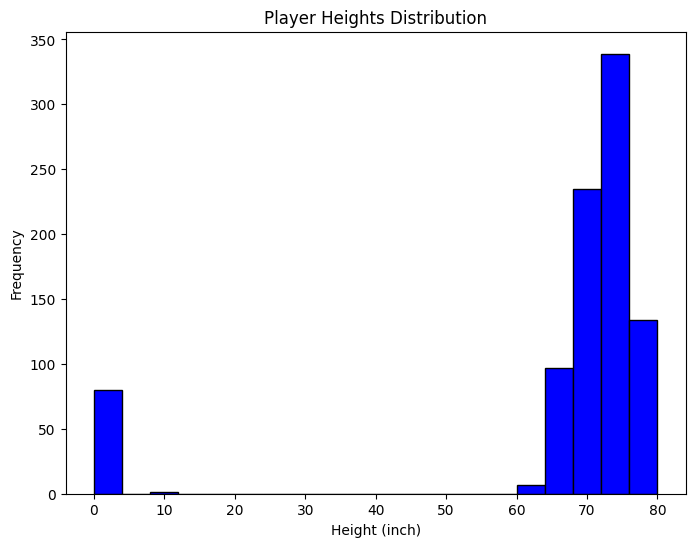

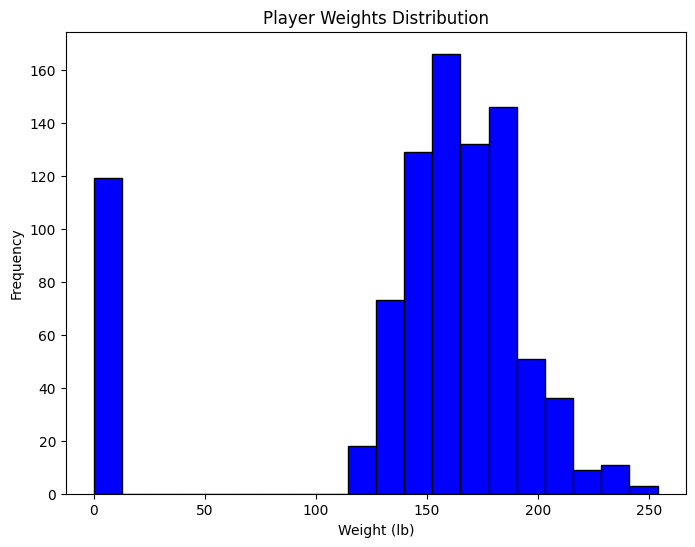

In [312]:
teams_df.dropna(inplace=True)
coaches_df.dropna(inplace=True)
players_df.dropna(inplace=True)
series_post_df.dropna(inplace=True)
players_teams_df.dropna(inplace=True)
awards_players_df.dropna(inplace=True)

plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Height (inch)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(players_df['weight'], bins=20, color='blue', edgecolor='black')
plt.title('Player Weights Distribution')
plt.xlabel('Weight (lb)')
plt.ylabel('Frequency')
plt.show()

In [313]:
merged_data = players_df.merge(players_teams_df, left_on='bioId', right_on='playerID')
result = merged_data[merged_data['height'] == 0]

print(result)



Empty DataFrame
Columns: [bioId, pos, firstseason, lastseason, height, weight, college, collegeOther, birthDate, deathDate, playerID, year, stint, tmID, lgID, GP, GS, minutes, points, oRebounds, dRebounds, rebounds, assists, steals, blocks, turnovers, PF, fAttempted, fgMade, ftattempted, ftMade, threeAttempted, threeMade, dq, PostGP, PostGS, PostMinutes, PostPoints, PostoRebounds, PostdRebounds, PostRebounds, PostAssists, PostSteals, PostBlocks, PostTurnovers, PostPF, PostfgAttempted, PostfgMade, PostftAttempted, PostftMade, PostthreeAttempted, PostthreeMade, PostDQ]
Index: []

[0 rows x 53 columns]


Since the players that have 0inches have all the other information as 0's and either are coaches or don't beleng to any team, we will drop them from the dataset.

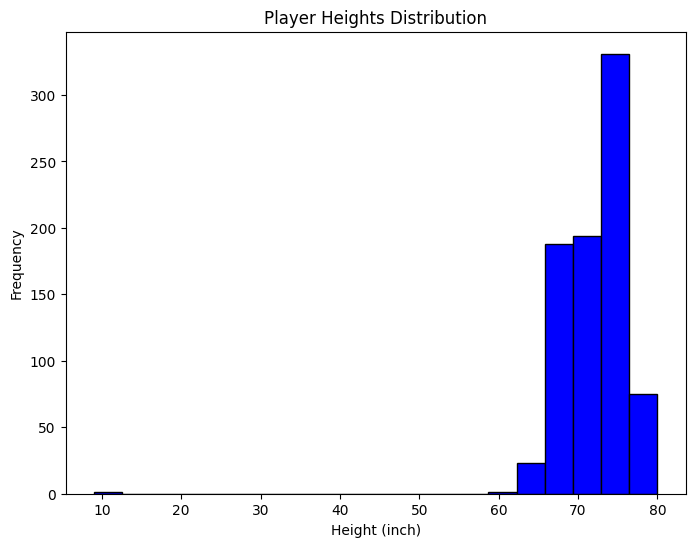

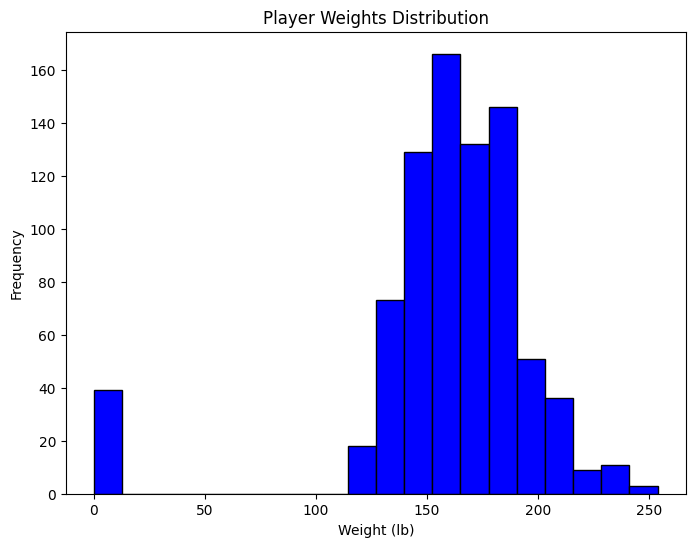

In [314]:
players_df = players_df[players_df['height'] > 0]
plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Height (inch)')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(8, 6))
plt.hist(players_df['weight'], bins=20, color='blue', edgecolor='black')
plt.title('Player Weights Distribution')
plt.xlabel('Weight (lb)')
plt.ylabel('Frequency')
plt.show()

As can be seen, even after taking out the players that have height as 0 and all the other columns as 0, there are still some players that have the weight as 0. To address this, we opted to replace the 0 value by the average weight of the players that have the same position

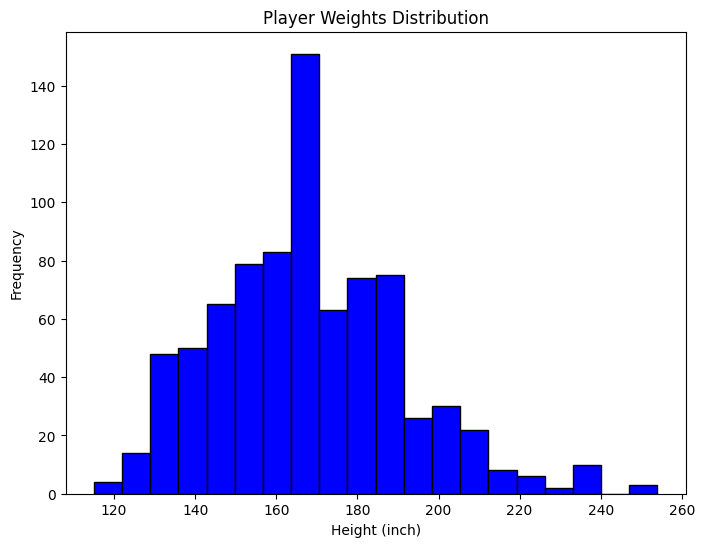

In [315]:
mean_weight = players_df[players_df['weight'] > 0]['weight'].mean()

players_df.loc[players_df['weight'] == 0, 'weight'] = mean_weight


plt.figure(figsize=(8, 6))
plt.hist(players_df['weight'], bins=20, color='blue', edgecolor='black')
plt.title('Player Weights Distribution')
plt.xlabel('Height (inch)')
plt.ylabel('Frequency')
plt.show()

#players_df.drop('avg_weight', axis=1, inplace=True)


As can be seen previously, there\'s still one player with a strange value in it's height.

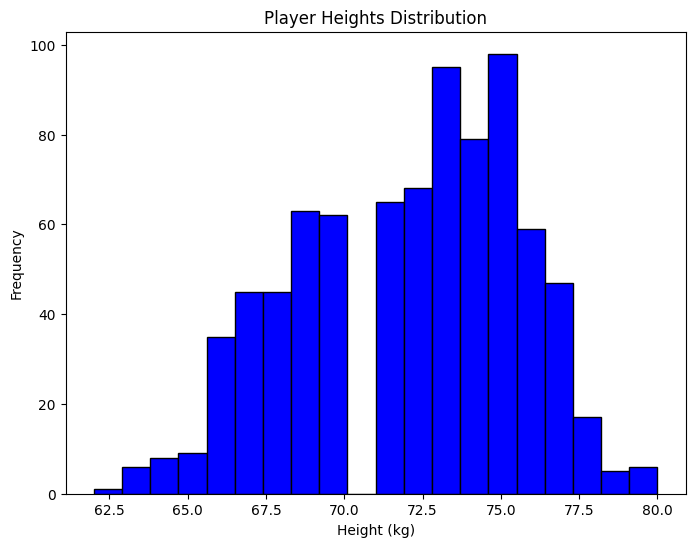

In [316]:
mean_height = players_df[players_df['height'] > 10]['height'].mean()

players_df.loc[players_df['height'] < 10, 'height'] = mean_height

players_df = players_df[players_df['height'] > 0]
plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Height (kg)')
plt.ylabel('Frequency')
plt.show()

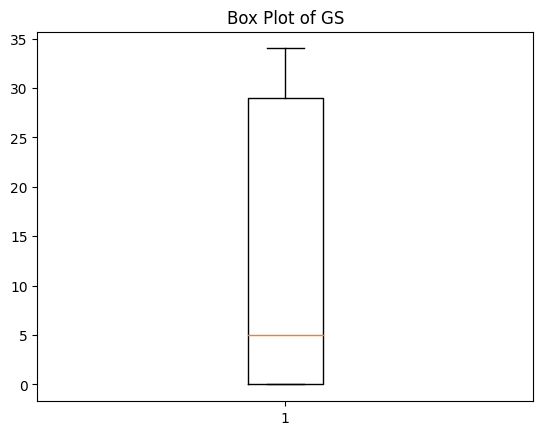

In [317]:
plt.boxplot(players_teams_df['GS'])
plt.title('Box Plot of GS')
plt.show()

In [318]:
# Check for missing values
awards_players_missing = awards_players_df.isnull().sum()

coaches_missing = coaches_df.isnull().sum()

players_teams_missing = players_teams_df.isnull().sum()

players_missing = players_df.isnull().sum()

series_post_missing = series_post_df.isnull().sum()

teams_missing = teams_df.isnull().sum()

# Print the results for each DataFrame
print("Missing values in awards_players_df:")
print(awards_players_missing)

print("Missing values in coaches_df:")
print(coaches_missing)

print("Missing values in players_teams_df:")
print(players_teams_missing)

print("Missing values in players_df:")
print(players_missing)

print("Missing values in series_post_df:")
print(series_post_missing)

print("Missing values in teams_df:")
print(teams_missing)

Missing values in awards_players_df:
playerID    0
award       0
year        0
lgID        0
dtype: int64
Missing values in coaches_df:
coachID        0
year           0
tmID           0
lgID           0
stint          0
won            0
lost           0
post_wins      0
post_losses    0
dtype: int64
Missing values in players_teams_df:
playerID              0
year                  0
stint                 0
tmID                  0
lgID                  0
GP                    0
GS                    0
minutes               0
points                0
oRebounds             0
dRebounds             0
rebounds              0
assists               0
steals                0
blocks                0
turnovers             0
PF                    0
fAttempted            0
fgMade                0
ftattempted           0
ftMade                0
threeAttempted        0
threeMade             0
dq                    0
PostGP                0
PostGS                0
PostMinutes           0
PostPoints    

As can be seen in the output of the last cell, the dataset has no missing values so there's no need to replace any of them.

In [319]:
columns_to_drop = players_teams_df.filter(like='Post', axis=1).columns
players_teams_df = players_teams_df.drop(columns=columns_to_drop)
players_teams_df = players_teams_df.drop(columns=['lgID', 'stint'])

players_teams_df.head()

,playerID,year,tmID,GP,GS,minutes,points,oRebounds,dRebounds,rebounds,...,blocks,turnovers,PF,fAttempted,fgMade,ftattempted,ftMade,threeAttempted,threeMade,dq
1,abrossv01w,2,MIN,26,23,846,343,43,131,174,...,9,85,70,293,114,132,96,76,19,2
2,abrossv01w,3,MIN,27,27,805,314,45,101,146,...,10,92,73,316,119,116,56,60,20,0
3,abrossv01w,4,MIN,30,25,792,318,44,97,141,...,11,90,79,285,112,98,69,82,25,0
4,abrossv01w,5,MIN,22,11,462,146,17,57,74,...,2,43,42,139,49,46,28,53,20,0
5,abrossv01w,6,MIN,31,31,777,304,29,78,107,...,6,80,86,276,109,73,53,82,33,0


Since we only want to know which teams are more likely to get to the playoffs, there is no need in having the information associated to the playoffs of the previous seasons. Therefore, the columns that contain this information will be dropped.

In [320]:
duplicate_records = players_teams_df.duplicated(keep='first')

# Original DataFrame shape (before removing duplicates)
original_shape = players_teams_df.shape

# Shape of the DataFrame after removing duplicates
new_shape = duplicate_records.shape

# Calculate the number of duplicates dropped
duplicates_dropped = original_shape[0] - new_shape[0]

# Print the number of duplicates dropped
print(f"Number of duplicates dropped: {duplicates_dropped}")


illogical_records = players_teams_df[players_teams_df['GS'] > players_teams_df['GP']]
illogical_count = len(illogical_records)

print(f"Number of illogical values: {illogical_count}")

Number of duplicates dropped: 0
Number of illogical values: 0


In [321]:
zero_gp_count = players_teams_df[players_teams_df['minutes'] == 0].groupby('year')['playerID'].count()

print(zero_gp_count)

players_teams_df.head()

year
9    3
Name: playerID, dtype: int64


,playerID,year,tmID,GP,GS,minutes,points,oRebounds,dRebounds,rebounds,...,blocks,turnovers,PF,fAttempted,fgMade,ftattempted,ftMade,threeAttempted,threeMade,dq
1,abrossv01w,2,MIN,26,23,846,343,43,131,174,...,9,85,70,293,114,132,96,76,19,2
2,abrossv01w,3,MIN,27,27,805,314,45,101,146,...,10,92,73,316,119,116,56,60,20,0
3,abrossv01w,4,MIN,30,25,792,318,44,97,141,...,11,90,79,285,112,98,69,82,25,0
4,abrossv01w,5,MIN,22,11,462,146,17,57,74,...,2,43,42,139,49,46,28,53,20,0
5,abrossv01w,6,MIN,31,31,777,304,29,78,107,...,6,80,86,276,109,73,53,82,33,0


In [322]:
teams_df_clean = teams_df[['year', 'tmID', 'confID', 'attend', 'playoff']]
players_df = players_df.drop(columns = ['lastseason', 'firstseason', 'deathDate', 'college', 'collegeOther'])

training_years = [2, 3, 4, 5, 6, 7, 8, 9, 10]

testing_set_with_stats = pd.DataFrame()

players_df = players_df.rename(columns={'bioId': 'playerID'})



for year in training_years:

    players_in_year = players_teams_df[players_teams_df['year'] == year]

    players_in_year = players_teams_df[players_teams_df['playerID'].isin(players_in_year['playerID'])]

    players_in_year = players_in_year[players_in_year['year'] < year]

    last_season_per_player = players_in_year.groupby('playerID')['year'].max().reset_index()

    last_season_stats = players_teams_df.merge(last_season_per_player, on=['playerID', 'year'], how='right')

    last_year_sum = last_season_stats.groupby('playerID').sum().reset_index()

    testing_set_for_year = last_year_sum.merge(players_df, on='playerID', how='left')

    # Add a 'year' column to indicate the year for which this data is used
    testing_set_for_year['year'] = year

    # Append the data for this year to the testing set DataFrame
    testing_set_with_stats = pd.concat([testing_set_with_stats, testing_set_for_year], ignore_index=True)

testing_set_with_stats.drop(columns=['tmID'], inplace=True)

players_teams_df= players_teams_df[['playerID', 'year', 'tmID']]

testing_set_with_stats = testing_set_with_stats.merge(players_teams_df, on=['playerID', 'year'], how='right')






In [323]:
testing_set_with_stats["birthDate"] = testing_set_with_stats["playerID"].map(players_df.set_index("playerID")["birthDate"])

testing_set_with_stats["height"] = testing_set_with_stats["playerID"].map(players_df.set_index("playerID")["height"])

testing_set_with_stats["weight"] = testing_set_with_stats["playerID"].map(players_df.set_index("playerID")["weight"])

testing_set_with_stats['birthDate'] = pd.to_datetime(testing_set_with_stats['birthDate'])

reference_year = 1999

testing_set_with_stats['age'] = reference_year + testing_set_with_stats['year']- testing_set_with_stats['birthDate'].dt.year





Calculate the age of each player assuming that the first season was in 1999

In [324]:
# player_count = testing_set_with_stats.groupby(['tmID', 'year'])['playerID'].nunique().reset_index()

# # Rename the 'playerID' column to 'player_count'
# player_count.rename(columns={'playerID': 'player_count'}, inplace=True)

# # Create a new DataFrame with only the specified columns
# player_count = player_count[['tmID', 'year', 'player_count']]

# teams_df_clean = teams_df_clean.merge(player_count, on = ['year', 'tmID'], how ='left')


agg_funcs = {
    'weight': 'mean', 
    'height': 'mean',  
    'age' : 'mean' 
}

# Group by 'tmID' and 'year' and apply the aggregation functions
mean_weight_height = testing_set_with_stats.groupby(['tmID', 'year']).agg(agg_funcs).reset_index()

mean_weight_height = mean_weight_height.round(2)

testing_set_with_stats = testing_set_with_stats.drop(columns=['birthDate', 'height', 'weight', 'age'])

testing_set_with_stats.drop(columns=['playerID', 'pos'], inplace=True)

team_year_averages = testing_set_with_stats.groupby(['tmID', 'year']).sum().reset_index()

team_year_averages = team_year_averages.round(2)

teams_df_clean = teams_df_clean.merge(team_year_averages, on = ['year', 'tmID'], how ='left')


Merge the dataframes "mean_weight_height" and "team_year_averages" into the dataframe "teams_df_clean"

In [325]:
teams_df_clean = teams_df_clean.merge(mean_weight_height, on = ['year', 'tmID'], how ='left')
teams_df_clean.head()

,year,tmID,confID,attend,playoff,GP,GS,minutes,points,oRebounds,...,fAttempted,fgMade,ftattempted,ftMade,threeAttempted,threeMade,dq,weight,height,age
0,9,ATL,EA,141379,N,300,97,5141,1769,250,...,1556,647,377,288,491,187,2,168.714286,73.214286,25.571429
1,10,ATL,EA,120737,Y,308,194,6972,2421,396,...,2149,884,717,506,459,147,11,159.076923,72.538462,26.615385
2,1,CHA,EA,90963,N,0,0,0,0,0,...,0,0,0,0,0,0,0,168.846154,71.692308,26.538462
3,2,CHA,EA,105525,Y,260,122,5729,1959,219,...,1668,686,552,425,511,162,6,164.416667,71.5,26.75
4,3,CHA,EA,106670,Y,338,179,6931,2155,340,...,1893,772,595,453,449,158,7,164.923077,71.307692,27.769231


In [326]:
awards_players_df = awards_players_df.rename(columns={'Kim Perrot Sportsmanship': 'Kim Perrot Sportsmanship Award'})


award_points =  {
    "All-Star Game Most Valuable Player": 2,
    "Defensive Player of the Year": 4,
    "Kim Perrot Sportsmanship Award": 1,
    "Most Improved Player": 2,
    "Most Valuable Player": 5,
    "Rookie of the Year": 3,
    "Sixth Woman of the Year": 2,
    "WNBA Finals Most Valuable Player": 4,
    "WNBA All-Decade Team": 1,
    "WNBA All Decade Team Honorable Mention": 1,
}

relevant_awards = awards_players_df[awards_players_df['award'].isin(award_points.keys())]

awards_players_teams = relevant_awards.merge(players_teams_df, on=['playerID', 'year'], how='left')

awards_players_teams['award_points'] = awards_players_teams['award'].map(award_points)

years_of_interest = [2,3,4,5,6,7,8,9,10] 

# Initialize an empty DataFrame to store the results
player_award_points = pd.DataFrame()


for year in years_of_interest: 
    
    previous_awards = awards_players_teams[awards_players_teams['year'] < year]

    player_yearly_award_points = previous_awards.groupby(['playerID'])['award_points'].sum().reset_index()

    player_yearly_award_points['year'] = year

    player_award_points = pd.concat([player_award_points, player_yearly_award_points], ignore_index=True)

player_award_points = player_award_points.merge(players_teams_df, on=['playerID', 'year'], how='left')

player_award_points = player_award_points.dropna(subset=['tmID'])

player_award_points = player_award_points.groupby(['tmID', 'year']).sum().reset_index()

teams_df_clean = teams_df_clean.merge(player_award_points, on = ['year', 'tmID'], how ='left')

teams_df_clean.drop(columns=['playerID'], inplace=True)

teams_df_clean.fillna(0, inplace=True)

teams_df_clean.head()

,year,tmID,confID,attend,playoff,GP,GS,minutes,points,oRebounds,...,fgMade,ftattempted,ftMade,threeAttempted,threeMade,dq,weight,height,age,award_points
0,9,ATL,EA,141379,N,300,97,5141,1769,250,...,647,377,288,491,187,2,168.714286,73.214286,25.571429,7.0
1,10,ATL,EA,120737,Y,308,194,6972,2421,396,...,884,717,506,459,147,11,159.076923,72.538462,26.615385,10.0
2,1,CHA,EA,90963,N,0,0,0,0,0,...,0,0,0,0,0,0,168.846154,71.692308,26.538462,0.0
3,2,CHA,EA,105525,Y,260,122,5729,1959,219,...,686,552,425,511,162,6,164.416667,71.5,26.75,0.0
4,3,CHA,EA,106670,Y,338,179,6931,2155,340,...,772,595,453,449,158,7,164.923077,71.307692,27.769231,0.0


In [327]:
coaches_record = pd.DataFrame()

for year in training_years:
    coaches_in_year = coaches_df[coaches_df['year'] == year]

    previous_season = coaches_df[coaches_df['year'] < year]

    filtered_previous_season = previous_season[previous_season['coachID'].isin(coaches_in_year['coachID'])]

    last_season_per_coach = filtered_previous_season.groupby('coachID')['year'].max().reset_index()

    last_season_stats = coaches_df.merge(last_season_per_coach, on=['coachID', 'year'], how='right')

    last_year_sum = last_season_stats.groupby('coachID').sum().reset_index()

    last_year_sum['year'] = year

    last_year_sum.drop(columns=['coachID', 'lgID', 'stint', 'post_wins', 'post_losses'], inplace=True)

    last_year_sum.rename(columns={'won': 'coachW', 'lost': 'coachL'}, inplace=True)

    coaches_record = pd.concat([coaches_record, last_year_sum], ignore_index=True)
    
teams_df_clean = teams_df_clean.merge(coaches_record, on=['year', 'tmID'], how='left')

teams_df_clean.fillna(0, inplace=True)


In [328]:
coach_points =  {
    "Coach of the Year": 3,
}
coaches_df_clean = coaches_df.copy()

coach_awards = awards_players_df[awards_players_df["award"] == "Coach of the Year"]
coach_awards.drop(columns=['lgID'], inplace=True)
coaches_df_clean.drop(columns=['lgID', 'stint', "won","lost","post_wins","post_losses", "tmID"], inplace=True)
coach_awards.rename(columns={'playerID': 'coachID'}, inplace=True)
coach_awards = coach_awards.merge(coaches_df_clean, on=['coachID', 'year'], how='left')
coach_awards['award_points'] = coach_awards['award'].map(coach_points)
coach_awards.drop(columns=['award'], inplace=True)


awards_year = pd.DataFrame()

for year in years_of_interest: 
    
    previous_awards = coach_awards[coach_awards['year'] < year]

    coach_yearly_award_points = previous_awards.groupby(['coachID'])['award_points'].sum().reset_index()

    coach_yearly_award_points['year'] = year

    awards_year = pd.concat([awards_year, coach_yearly_award_points], ignore_index=True)



awards_year = awards_year.merge(coaches_df[["year", "coachID", "tmID"]], on=['coachID', 'year'], how='left')

awards_year.drop(columns=['coachID'], inplace=True)

awards_year = awards_year.dropna(subset=['tmID'])

teams_df_clean = teams_df_clean.merge(awards_year, on=['year', 'tmID'], suffixes=('_df1', '_df2'), how='left')

teams_df_clean.fillna(0, inplace=True)

teams_df_clean['combined_awards_points'] = teams_df_clean['award_points_df1'] + teams_df_clean['award_points_df2']

teams_df_clean.drop(columns=['award_points_df1', 'award_points_df2'], inplace=True)

teams_df_clean.rename(columns={'combined_awards_points': 'awards_points'}, inplace=True)

teams_df_clean.to_csv('teams_df_clean.csv', index=False)






/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_1302/433238594.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coach_awards.drop(columns=['lgID'], inplace=True)
/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_1302/433238594.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coach_awards.rename(columns={'playerID': 'coachID'}, inplace=True)


In [329]:
teams_df_clean.drop(columns=['attend'], inplace=True)
columns_to_exclude = ['year', 'tmID', 'confID', 'playoff', 'weight','age','height']

columns_to_normalize = [col for col in teams_df_clean.columns if col not in columns_to_exclude]

le = LabelEncoder()
teams_df_clean['tmID'] = le.fit_transform(teams_df_clean['tmID'])
teams_df_clean['confID'] = le.fit_transform(teams_df_clean['confID'])
teams_df_clean['playoff'].replace({'N': 0, 'Y': 1}, inplace=True)

teams_df_clean_normalize = teams_df_clean.copy()

teams_df_clean_normalize[columns_to_normalize] = (teams_df_clean_normalize[columns_to_normalize] - teams_df_clean_normalize[columns_to_normalize].mean()) / teams_df_clean_normalize[columns_to_normalize].std()

teams_df_clean= teams_df_clean_normalize.copy()





In [330]:
target_year = 10
training_set = teams_df_clean[(teams_df_clean['year'] < target_year) | (teams_df_clean['year'] > target_year)]
testing_set = teams_df_clean[teams_df_clean['year'] == target_year]

X_train = training_set.drop(columns = "playoff", axis = 1)
y_train = training_set['playoff']

X_test = testing_set.drop(columns = "playoff", axis = 1)
y_test = testing_set['playoff']


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

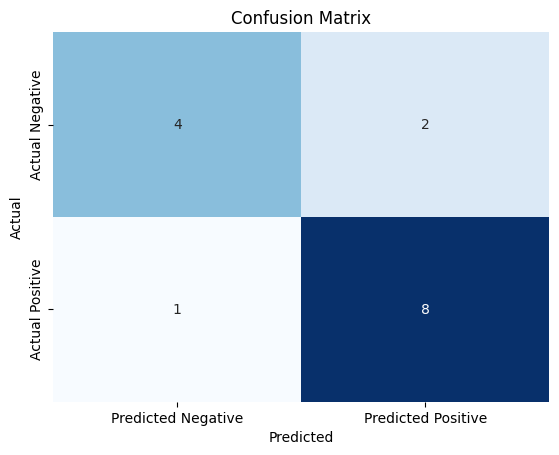

Accuracy: 0.80
AUC: 0.83
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.80      0.89      0.84         9

    accuracy                           0.80        15
   macro avg       0.80      0.78      0.78        15
weighted avg       0.80      0.80      0.80        15



In [334]:
training_set_normalize = teams_df_clean_normalize[(teams_df_clean_normalize['year'] < target_year) | (teams_df_clean_normalize['year'] > target_year)]
testing_set_normalize = teams_df_clean_normalize[teams_df_clean_normalize['year'] == target_year]

X_train_normalize = training_set_normalize.drop(columns = "playoff", axis = 1)
y_train_normalize = training_set_normalize['playoff']

X_test_normalize = testing_set_normalize.drop(columns = "playoff", axis = 1)
y_test_normalize = testing_set_normalize['playoff']


logistic_regression = LogisticRegression()

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [500, 1000, 1500],
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_normalize, y_train_normalize)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_model.fit(X_train_normalize, y_train_normalize)

y_probabilities = best_model.predict_proba(X_test_normalize)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test_normalize, y_probabilities)

predictions = best_model.predict(X_test_normalize)


threshold = 0.5  # You can adjust the threshold based on your preference
predictions = (y_probabilities >= threshold).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_normalize, predictions)

# Plot the confusion matrix using seaborn
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

accuracy = accuracy_score(y_test_normalize, predictions)
classification_rep = classification_report(y_test_normalize, predictions)
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc_score:.2f}')
print(classification_rep)




In [332]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

y_probabilities = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_probabilities)

predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
classification_rep = classification_report(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc_score:.2f}')
print(classification_rep)

KeyboardInterrupt: 

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=10)

knn_classifier.fit(X_train, y_train)

predictions = knn_classifier.predict(X_test)

y_probabilities = knn_classifier.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_probabilities)



accuracy = accuracy_score(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc_score:.2f}')
print(classification_rep)

Accuracy: 0.60
AUC: 0.74
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.62      0.89      0.73         9

    accuracy                           0.60        15
   macro avg       0.56      0.53      0.49        15
weighted avg       0.57      0.60      0.54        15



Accuracy: 0.40
AUC: 0.39
              precision    recall  f1-score   support

           0       0.29      0.33      0.31         6
           1       0.50      0.44      0.47         9

    accuracy                           0.40        15
   macro avg       0.39      0.39      0.39        15
weighted avg       0.41      0.40      0.41        15



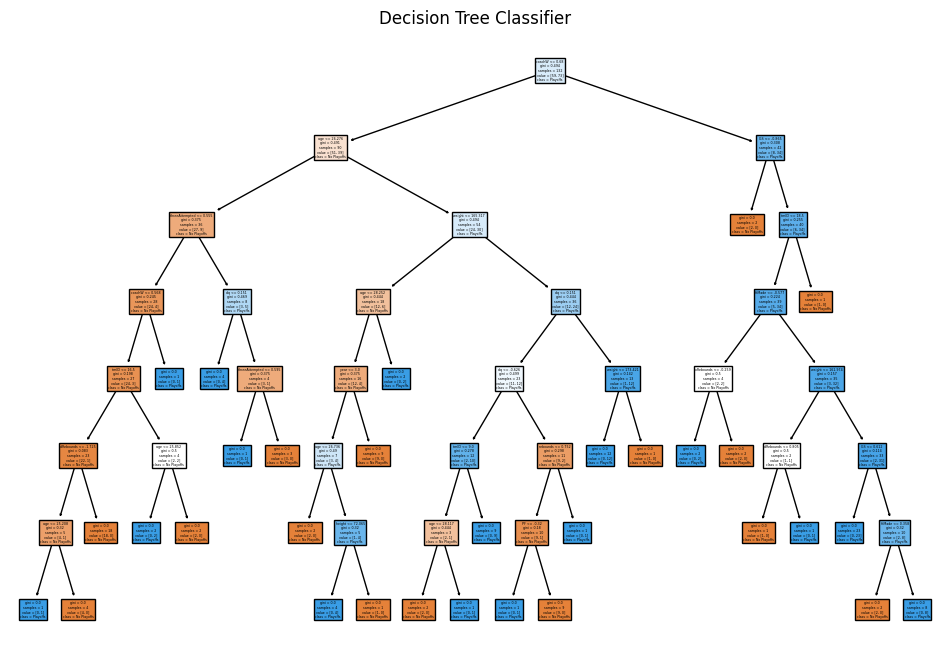

                    year      tmID    confID   playoff        GP        GS  \
year            1.000000 -0.027997  0.030006  0.055933  0.579206  0.490975   
tmID           -0.027997  1.000000  0.434424 -0.019703 -0.042495 -0.052177   
confID          0.030006  0.434424  1.000000 -0.038226  0.007083 -0.004236   
playoff         0.055933 -0.019703 -0.038226  1.000000  0.042136  0.172069   
GP              0.579206 -0.042495  0.007083  0.042136  1.000000  0.867173   
GS              0.490975 -0.052177 -0.004236  0.172069  0.867173  1.000000   
minutes         0.531455 -0.058702 -0.012033  0.132816  0.963842  0.953753   
points          0.610987 -0.034904  0.051696  0.154546  0.921912  0.933259   
oRebounds       0.533420 -0.052888 -0.026355  0.129419  0.922321  0.901679   
dRebounds       0.601300 -0.050623  0.043051  0.195318  0.924706  0.926355   
rebounds        0.586572 -0.051930  0.021398  0.176540  0.934610  0.929164   
assists         0.563486 -0.075919  0.024954  0.203526  0.905931

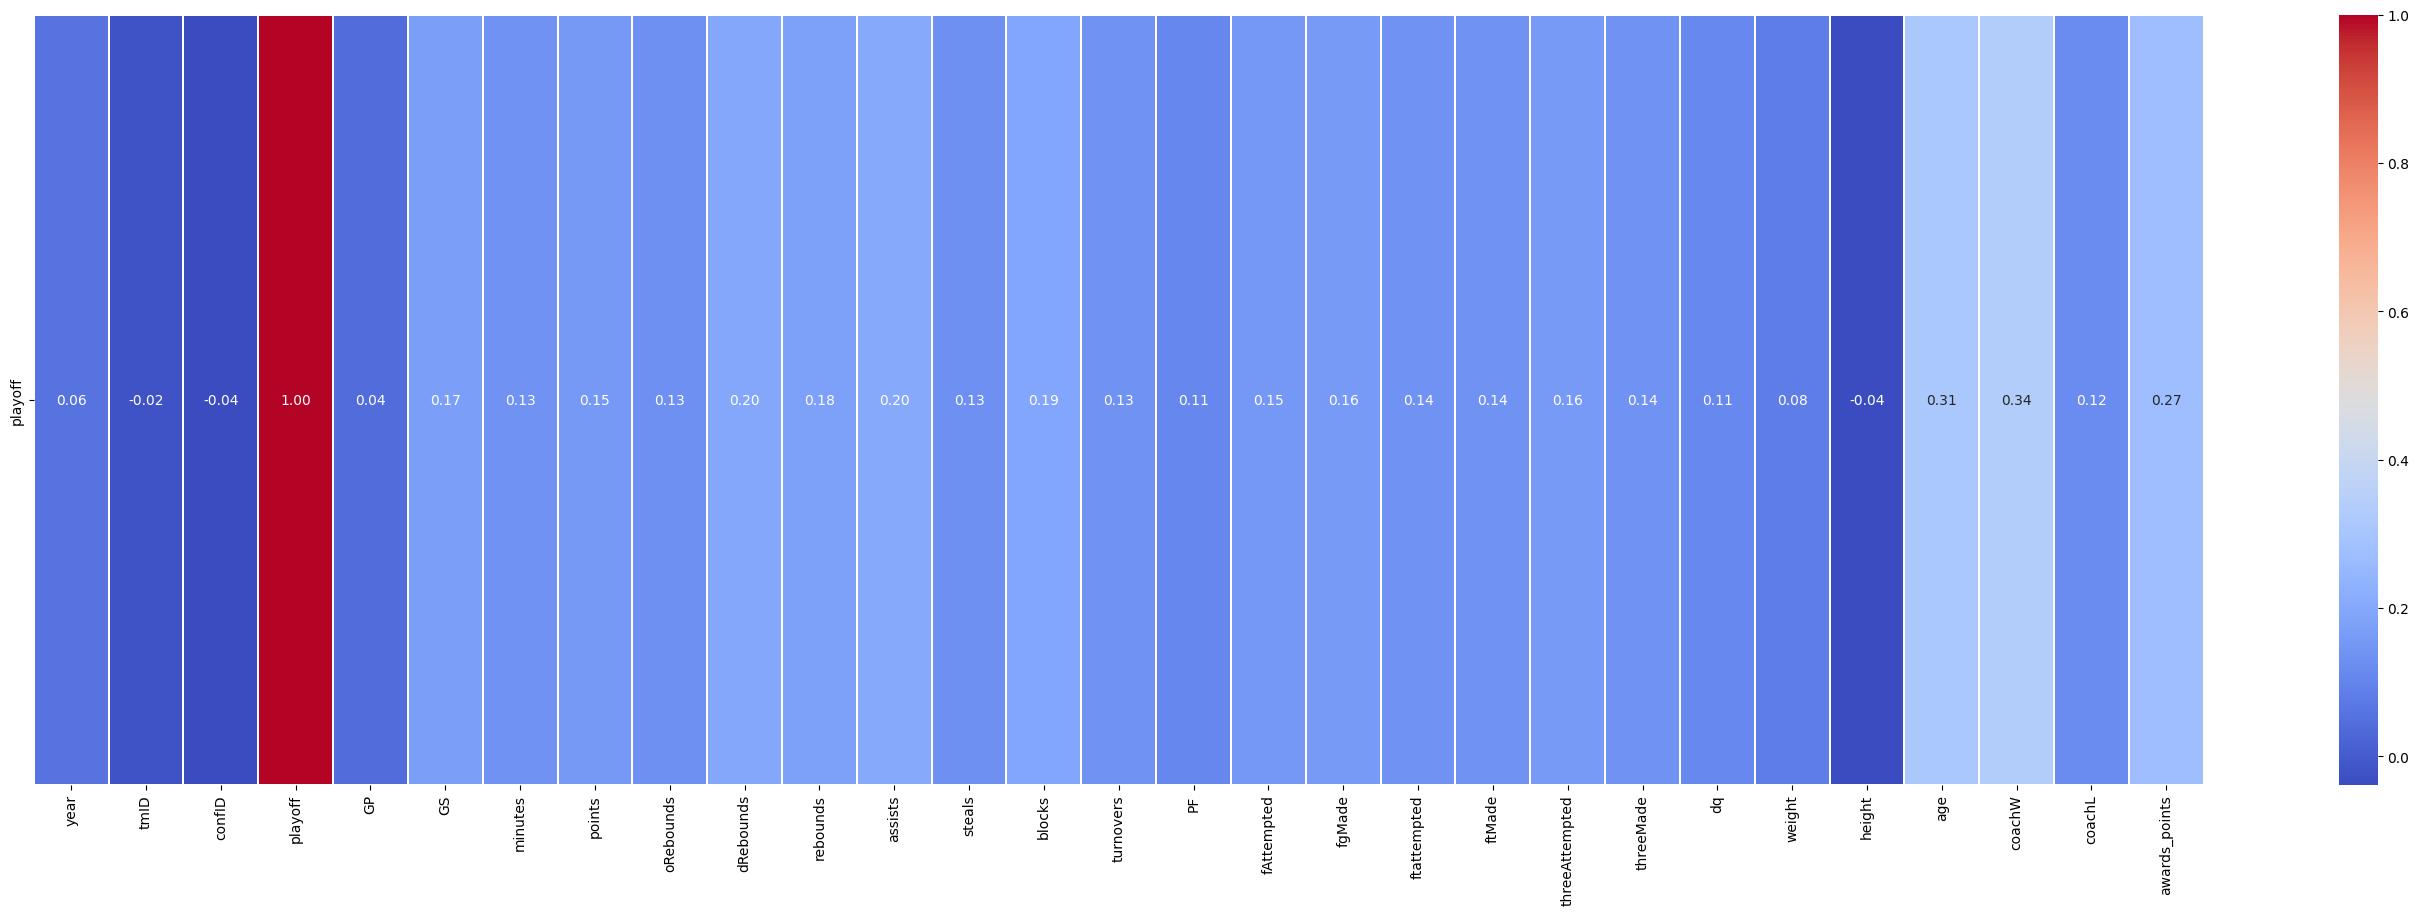

In [ ]:
decision_tree_classifier = DecisionTreeClassifier(random_state=10)

decision_tree_classifier.fit(X_train, y_train)

predictions = decision_tree_classifier.predict(X_test)

y_probabilities = decision_tree_classifier.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_probabilities)

accuracy = accuracy_score(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc_score:.2f}')
print(classification_rep)

# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree_classifier, filled=True, feature_names=X_train.columns, class_names=["No Playoffs", "Playoffs"])
plt.title("Decision Tree Classifier")
plt.show()


correlation_matrix = teams_df_clean.corr()
print(correlation_matrix)

plt.figure(figsize=(35, 10))
sb.heatmap(correlation_matrix[['playoff']].transpose(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.3)
plt.show()